<a href="https://colab.research.google.com/github/cccadet/dermatologist-ai/blob/master/01_Train1_ISIC_2019_model7_ResNet_V2_152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré: Conexão com Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Etapa 1: Instalação das dependências

### Instalação de bibliotecas

In [3]:
!pip install tensorflow-gpu
!pip install tqdm
#!pip install tensorflow-addons
!pip install tfa-nightly
!pip install deepstack

     |████████████████████████████████| 320.4MB 46kB/s 
     |████████████████████████████████| 1.1MB 4.6MB/s 


### Importação das bibliotecas

In [4]:
import zipfile
import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import pandas as pd
import sys
import itertools
import shutil

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.3.0'

### Otimizações tensorflow

In [5]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.config.optimizer.set_jit(True)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Fazendo o download da base de dados de imagens

In [6]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip \
      -O ./skin_cancer_train_2018.zip


--2020-08-30 00:50:19--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.17.188
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.17.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘./skin_cancer_train_2018.zip’

./skin_cancer_train 100%[===================>]   2.58G  45.4MB/s    in 59s     

2020-08-30 00:51:19 (44.6 MB/s) - ‘./skin_cancer_train_2018.zip’ saved [2771732744/2771732744]

CPU times: user 336 ms, sys: 113 ms, total: 449 ms
Wall time: 59.8 s


In [7]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip \
      -O ./skin_cancer_train_2019.zip

--2020-08-30 00:51:19--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘./skin_cancer_train_2019.zip’

./skin_cancer_train 100%[===================>]   9.10G  38.4MB/s    in 5m 25s  

2020-08-30 00:56:44 (28.7 MB/s) - ‘./skin_cancer_train_2019.zip’ saved [9771618190/9771618190]

CPU times: user 1.73 s, sys: 560 ms, total: 2.29 s
Wall time: 5min 25s


## Etapa 2: Pré-processamento

### Configurando os caminhos (paths)

In [8]:
train_dir = "./train"
if not os.path.exists(train_dir): 
  os.mkdir(train_dir)
valid_dir = "./valid"
if not os.path.exists(valid_dir): 
  os.mkdir(valid_dir)


download_path = './'
derm_ai_path = '/content/drive/My Drive/Derm AI/ISIC_2019'


### Definindo função para descompactar arquivo

In [9]:
def dcp(download_path, path, file):
  if (os.path.isdir(path)==False):
    dataset_path = os.path.join(download_path,file)
    zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
    zip_object.extractall("./")
    zip_object.close()

### Descompactando a base de dados de Treinamento

In [10]:
%%time
dcp(download_path, './ISIC2018_Task3_Training_Input', 'skin_cancer_train_2018.zip')

CPU times: user 5.7 s, sys: 3.71 s, total: 9.41 s
Wall time: 1min 22s


In [11]:
!rm ./skin_cancer_train_2018.zip

In [12]:
%%time
dcp(download_path, './ISIC_2019_Training_Input', 'skin_cancer_train_2019.zip')

CPU times: user 43.4 s, sys: 12.6 s, total: 55.9 s
Wall time: 4min 45s


In [13]:
!rm ./skin_cancer_train_2019.zip

### Definindo DataFrame base para criação das pastas de cada classe

In [14]:
!wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip \
      -O ./ground_truth.zip


zip_object = zipfile.ZipFile(file='ground_truth.zip', mode="r")
zip_object.extractall("./")
zip_object.close()

--2020-08-30 01:02:53--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.1.36
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.1.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36681 (36K) [application/zip]
Saving to: ‘./ground_truth.zip’

./ground_truth.zip  100%[===================>]  35.82K  --.-KB/s    in 0.07s   

2020-08-30 01:02:54 (538 KB/s) - ‘./ground_truth.zip’ saved [36681/36681]



In [15]:
# Read in the data
ground_truth1 = pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')
ground_truth2 = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
ground_truth2['AK'] = ground_truth2['AKIEC']
ground_truth2.drop(columns=['AKIEC'], inplace=True)
ground_truth = pd.concat([ground_truth1,ground_truth2])

# Display some information in the dataset
ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
!mkdir ISIC_Training_Input
!mv /content/ISIC2018_Task3_Training_Input/*.jpg /content/ISIC_Training_Input
!mv /content/ISIC_2019_Training_Input/*.jpg /content/ISIC_Training_Input

### Separando base de treinamento e de validação

In [17]:
# Set y as the labels
y = []
for row in ground_truth.iterrows():
    innerlist = []
    newlist = row[1].index[row[1].values[1:].argmax() + 1]
    y.append(newlist)


#add a name to the label series
yd = pd.Series(y) 
yd.name = 'cclass'

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(ground_truth, test_size=0.2, random_state=41, stratify=yd)

# Get a list of images in each of the two folders
folder = os.listdir('ISIC_Training_Input')

# Get a list of train and val images
#all_list = list(ground_truth['image'])
#
train_list = list(df_train['image'])
val_list = list(df_val['image'])

### Criando subdiretório das classes

In [18]:
#create sub directory for the classes
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        dir_path = os.path.join(train_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)
        dir_path = os.path.join(valid_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)

### Transferindo arquivos - base de treinamento

In [19]:
%%time
# Transfer the training images
for row in df_train.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 14.8 s, sys: 13.9 s, total: 28.7 s
Wall time: 3min 52s


### Transferindo arquivos - base de validação

In [20]:
%%time
# Transfer the valid images
for row in df_val.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(valid_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 3.74 s, sys: 3.37 s, total: 7.12 s
Wall time: 1min 2s


### Números das bases de treinamento

In [21]:
# training examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 3790
NV 11392
BCC 2749
AK 874
BKL 2277
DF 211
VASC 233
SCC 502
total =  22028


### Números das bases de validação

In [22]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 1086
NV 3637
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  6669


### Balanceamento base de validação

In [23]:
import os, random
mellen = len(os.listdir('./valid/MEL'))
nvlen = len(os.listdir('./valid/NV'))
for i in range(nvlen - mellen):
    file = random.choice(os.listdir("./valid/NV"))
    dst = os.path.join(valid_dir,'NV', file)
    os.remove(dst)

In [24]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

MEL 1086
NV 1086
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  4118


AK
BCC
BKL
DF
MEL Melanoma
NV
SCC
VASC

### Criando pesos das classes

### Criando geradores de dados (Data Generators)


In [25]:
# Data Augmentation (https://keras.io/preprocessing/image/)
data_gen_train = ImageDataGenerator(#validation_split=0.2,
                                    rescale=1/255., 
                                    horizontal_flip= True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.10, 
                                    width_shift_range=0.10,
                                    rotation_range=180,
                                    shear_range=0.01,
                                    zoom_range=[0.95, 1.25],
                                    fill_mode='constant',
                                    #data_format='channels_last',
                                    brightness_range=[0.9, 1.1]
                                    )

data_gen_valid = ImageDataGenerator(rescale=1/255., 
                                   fill_mode="constant"
)



In [31]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False)
valid_generator = data_gen_valid.flow_from_directory(valid_dir, target_size=(224,224), batch_size=32, class_mode="categorical", shuffle=False)

steps_per_epoch = len(train_generator)

Found 22028 images belonging to 8 classes.
Found 4118 images belonging to 8 classes.


#### Exibição de 3 imagens carregadas

[0. 1. 0. 0. 0. 0. 0. 0.]


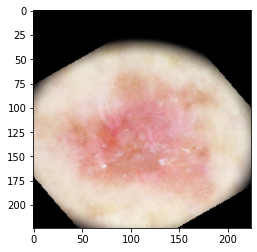

[0. 0. 0. 0. 1. 0. 0. 0.]


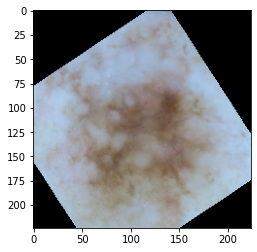

[0. 0. 0. 0. 0. 1. 0. 0.]


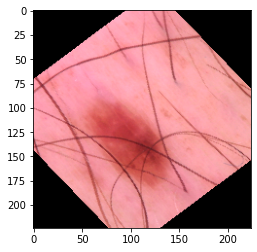

In [27]:
x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [28]:
import numpy as np

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(train_generator.classes), class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes))) 


class_weights
train_generator.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

## Etapa 3: Construindo o modelo

### Carregando o modelo pré-treinado (InceptionResNetV2)

In [32]:
img_shape = (224, 224, 3)
base_model = tf.keras.applications.InceptionResNetV2(input_shape = img_shape, 
                                               include_top = False,
                                               weights = "imagenet")

#base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_152/classification/4", trainable=False, arguments=dict(batch_norm_momentum=0.997))

base_model.trainable = False #@param {type:"boolean"}
prediction_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
"""global_average_layer = tf.keras.layers.Dropout(0.2)global_average_layer(global_average_layer)
global_average_layer = tf.keras.layers.Dense(1024, activation="relu")(global_average_layer)
global_average_layer = tf.keras.layers.Dropout(0.2)(global_average_layer)
global_average_layer = tf.keras.layers.Dense(512, activation="relu")(global_average_layer)
prediction_layer = tf.keras.layers.Dense(units = 8, activation = "softmax")(global_average_layer)"""
model = tf.keras.models.Model(inputs = base_model.input, outputs = prediction_layer)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 111, 111, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 111, 111, 32) 0           batch_normalization_203[0][0]    
_______________________________________________________________________________________

In [33]:
features = model.predict(train_generator)
X_train = features.squeeze()
y_train = train_generator.labels
len(y_train)-len(X_train)

In [46]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(max_depth=15, learning_rate=0.1, n_estimators=200, \
                              objective='multi:softmax', nthread=-1, \
                              subsample=0.7, colsample_bytree=0.7, seed=142, missing=None, tree_method='gpu_hist', verbosity=2, predictor='gpu_predictor')
model_xgb.fit(X_train, y_train)
#y_pred[:, class_i] = model.predict_proba(X_test)[:, 1]

In [47]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=-1, objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=142, silent=None, subsample=0.7, tree_method='gpu_hist',
              verbosity=2)

In [48]:
features_test = model.predict(valid_generator)
X_test = features_test.squeeze()
y_test= valid_generator.labels
len(X_test)-len(y_test)

0

In [49]:
from sklearn.metrics import accuracy_score
y_pred = model_xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

In [50]:
accuracy

0.48542982030111703

In [51]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
model6 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'B1-IRN50V2_3'))
model6.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 10, 10, 1280) 6575239     input_3[0][0]                    
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 8, 8, 1536)   54336736    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnetb1[0][0]             
_______________________________________________________________________________________

In [52]:
layer_name = "concatenate"
prediction_layer = model6.get_layer(layer_name).output
model2 = tf.keras.models.Model(inputs = model6.input, outputs = prediction_layer)
model2.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 10, 10, 1280) 6575239     input_3[0][0]                    
__________________________________________________________________________________________________
inception_resnet_v2 (Functional (None, 8, 8, 1536)   54336736    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnetb1[0][0]             
_______________________________________________________________________________________

In [53]:
train_generator2 = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=32, class_mode="categorical", shuffle=False)
valid_generator2 = data_gen_valid.flow_from_directory(valid_dir, target_size=(299,299), batch_size=32, class_mode="categorical", shuffle=False)

Found 22028 images belonging to 8 classes.
Found 4118 images belonging to 8 classes.


In [54]:
%%time
features = model6.predict(train_generator2)
X_train = features.squeeze()
y_train = train_generator2.labels
len(y_train)-len(X_train)

0

In [55]:
%%time
model_xgb2 = xgb.XGBClassifier(max_depth=15, learning_rate=0.1, n_estimators=200, \
                              objective='multi:softmax', nthread=-1, \
                              subsample=0.7, colsample_bytree=0.7, seed=142, missing=None, tree_method='gpu_hist', verbosity=2, predictor='gpu_predictor')
model_xgb2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=-1, objective='multi:softprob', predictor='gpu_predictor',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=142, silent=None, subsample=0.7, tree_method='gpu_hist',
              verbosity=2)

In [58]:
%%time
features_test = model6.predict(valid_generator2)
X_test = features_test.squeeze()
y_test= valid_generator2.labels
len(X_test)-len(y_test)

CPU times: user 1min 12s, sys: 7.6 s, total: 1min 19s
Wall time: 1min 6s


In [59]:
from sklearn.metrics import accuracy_score
y_pred = model_xgb2.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracy

0.8081593006313744

In [61]:
import pickle
file_name = os.path.join(derm_ai_path, 'model_xgb2.pkl')

# save
pickle.dump(model_xgb2, open(file_name, "wb"))

In [62]:
# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

[02:33:56] INFO: /workspace/src/learner.cc:370: Parameter 'predictor' has been recovered from the saved model. It will be set to 'gpu_predictor' for prediction. To override the predictor behavior, explicitly set 'predictor' parameter as follows:
  * Python package: bst.set_param('predictor', [new value])
  * R package:      xgb.parameters(bst) <- list(predictor = [new value])
  * JVM packages:   bst.setParam("predictor", [new value])


In [63]:
from sklearn.metrics import accuracy_score
y_pred = xgb_model_loaded.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracy

0.8081593006313744

### Definindo o cabeçalho personalizado da rede neural

In [ ]:
#!pip install -q tensorflow-hub
#!pip install -q tensorflow-datasets

"""feature_extractor_url = "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4"

#feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4"
#feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(331,331,3))
feature_extractor_layer.trainable = False #@param {type:"boolean"}
model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024, activation="relu"),
  tf.keras.layers.Dropout(0.2),
 tf.keras.layers.Dense(512, activation="relu"),
 tf.keras.layers.Dense(units = 8, activation = "softmax")
])

model.summary()"""

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_8 (KerasLayer)   (None, 4320)              81913656  
_________________________________________________________________
dropout_8 (Dropout)          (None, 4320)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              4424704   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 4104      
Total params: 86,867,264
Trainable params: 4,953,608
Non-trainable params: 81,913,656
__________________________________

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['categorical_accuracy'])
    self.model.reset_metrics()

In [ ]:
batch_stats_callback = CollectBatchStats()

history = model.fit(train_generator, epochs=2,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/2
689/689 [==============================] - 697s 1s/step - loss: 1.7576 - categorical_accuracy: 0.5162
Epoch 2/2
689/689 [==============================] - 706s 1s/step - loss: 1.7568 - categorical_accuracy: 0.5172


In [ ]:
loss, accuracy = model.evaluate(valid_generator)
print('Test accuracy :', accuracy)

129/129 [==============================] - 63s 490ms/step - loss: 2.0103 - categorical_accuracy: 0.2637
Test accuracy : 0.26372024416923523


In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

KeyError: ignored

In [ ]:
feature_extractor_layer.trainable = True #@param {type:"boolean"}
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 2048)              58331648  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4104      
Total params: 60,958,728
Trainable params: 60,814,984
Non-trainable params: 143,744
____________________________________

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='categorical_accuracy', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True)

history_fine = model.fit(train_generator, epochs=20,
                    steps_per_epoch=steps_per_epoch, callbacks=[early_stopping])

Epoch 1/20
 16/689 [..............................] - ETA: 8:06 - loss: 1.7527 - categorical_accuracy: 0.5234

KeyboardInterrupt: ignored

In [ ]:
acc += history_fine.history['categorical_accuracy']
val_acc += history_fine.history['val_categorical_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_generator)
print('Test accuracy :', accuracy)

In [ ]:
model_filepath = os.path.join(derm_ai_path, 'model7_NasLarge')
model.save(model_filepath)

In [ ]:
#model_filepath = os.path.join(derm_ai_path, 'model7_ResNet_V2_152')
#model.save(model_filepath)

In [ ]:
image_batch, label_batch = next(iter(valid_generator))
print(feature_batch.shape)

In [ ]:
reloaded = tf.keras.models.load_model(model_filepath)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()